In [114]:
import MLP_Olaf as ML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import seaborn as sns

# Wstęp

Celem tego sprawozdania jest przeprowadzenie testów mojej implementacji sieci neuronowej.
Będzie parę eksperymentów. Każdy eksperyment bedzie opisany przez warunki eksperymentu, hipotezę, wyniki i wnioski. Z założenia wszystkie dane na których przeprowadzam eksperymenty są zestandaryzowane. Poza tym dla problemów klasyfikacji dane są w kodowaniu "one-hot". Będziemy przeprowadzać testy na zbiorach: xor3, rings5-regular, square-simple i multimodal-small. Wagi sieci będą inicjowane losowo, jednostajnie z przedziału [-1, 1].
Podczas eksperymentów sieci będą startować z tymi samymi wagami jeśli mają tyle samo neuronów w każdej warstwie dla danego zbioru. Dla problemów klasyfikacji używany jest softmax na ostatniej warstwie. Dla problemów klasyfikacji liczymy accuracy i cross entropy, ale trenujemy używając cross entropy. Dla problemów regresji używamy MSE.

In [87]:
df=pd.DataFrame(columns=["model_n","problem","dataset","columns_input","columns_output",
                  "rows_train","rows_test","layers","neurons","connections",
                  "L1","L2","regularization","alpha","activation_function",
                         "validate","score_train","score_test","cost_function",
                         "epochs","time","rate","beta","RMSprop","batch"])

In [88]:
MAX_EPOCH=100

In [89]:
networks=[]

networks_names=[]

networks_err=[]

np.random.seed(123)

model_n=0

# Eksperyment 1 wpływ ilości warstw i neuronów na uczenie

Zbadamy wpływ ilości warstw i neuronów na proces uczenia. Zastosujemy tradycyjną metodę spadku gradientu, za learning rate biorąc 0.1, a naszą funkcją aktywacji będzie sigmoid. Za stop mamy przekroczenie liczby epok równe 1000 lub bewzględną zmianę błędu mniejszą niż 10**-6. Nie używamy batchy. Takie warunki będziemy nazywać "podstawowymi". Będziemy testować następujące architektury: [5],[5,5],[10],[3,4,3],[6,6,6],[3,3,3,3].

# Hipoteza: im więcej połączeń miedzy neuronomi tym lepiej, zaś sama liczba neuronów nie jest już tak znacząca

## square-simple

In [90]:
test = np.loadtxt("mio1/regression/square-simple-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))
np.random.shuffle(test)
X=test[:,0:1]
Y=test[:,1:2]
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=(Y-np.mean(Y,axis=0))/np.std(Y,axis=0)

In [91]:
test = np.loadtxt("mio1/regression/square-simple-test.csv", delimiter=',', skiprows=1, usecols=range(1,3))
X1=test[:,0:1]
Y1=test[:,1:2]
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=(Y1-np.mean(Y,axis=0))/np.std(Y,axis=0)

[Text(0.5, 1.0, 'Training Set')]

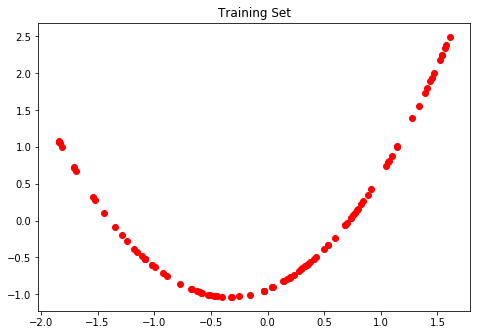

In [92]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.set(title="Training Set")

In [93]:
for L in [[5],[5,5],[10],[3,4,3],[6,6,6],[3,3,3,3]]:
    mlp_test=ML.MLP_new(1,1,L,[ML.sigmoid]*len(L)+[ML.identity],[ML.sigmoid_grad]*len(L)+[ML.identity_grad],ML.MSE,ML.MSE_grad)
        
    start_time = time.time()
    er=mlp_test.train(train_input_layer,train_output_layer,max_epoch=MAX_EPOCH,Verbose=False)
    end_time = time.time()
    t=end_time - start_time
        
    networks.append(deepcopy(mlp_test))
    networks_err.append(er.copy())
    networks_names.append("square-simple-"+str(L))
    
    output_layer=mlp_test.calculate(train_input_layer)
    score_train=ML.MSE(train_output_layer,output_layer)/output_layer.shape[0]
    output_layer=mlp_test.calculate(test_input_layer)
    score_test=ML.MSE(test_output_layer,output_layer)/output_layer.shape[0]
    
    L1=sum([np.sum(w**2) for w in mlp_test.weights])
    L2=sum([np.sum(np.abs(w)) for w in mlp_test.weights])
    
    rows_train=train_input_layer.shape[0]
    rows_test=test_input_layer.shape[0]
    columns_input=train_input_layer.shape[1]
    columns_output=train_output_layer.shape[1]
    connections=sum([L[i]*L[i+1] for i in range(len(L)-1)])+columns_input*L[0]+columns_output*L[-1]
    neurons=sum(L)
    L1=L1/connections
    L2=L2/connections
    model_n+=1
    df=df.append({"model_n":model_n,"problem":"regresion","dataset":"square-simple","columns_input":columns_input,"columns_output":columns_output,
                  "rows_train":rows_train,"rows_test":rows_test,"layers":len(L),"neurons":neurons,"connections":connections,
                  "L1":L1,"L2":L2,"regularization":"None","alpha":0,"activation_function":"sigmoid",
                         "validate":0,"score_train":score_train,"score_test":score_test,"cost_function":"MSE",
                         "epochs":len(er)-1,"time":t,"rate":0.1,"beta":0,"RMSprop":False,"batch":1},ignore_index=True)

start error 141.15292531729798
end in epoch 100 with error 90.16041659824742
start error 141.7602660028694
end in epoch 100 with error 93.85326218771186
start error 215.07170035823086
end in epoch 100 with error 81.46243605437766
start error 112.13568816118298
end in epoch 100 with error 99.97110108721168
start error 105.1073618447293
end in epoch 100 with error 98.65811777537084
start error 140.38359332244215
end in epoch 31 with error 99.97924718487688


## Best Model

[Text(0.5, 1.0, 'Test data score: 0.459')]

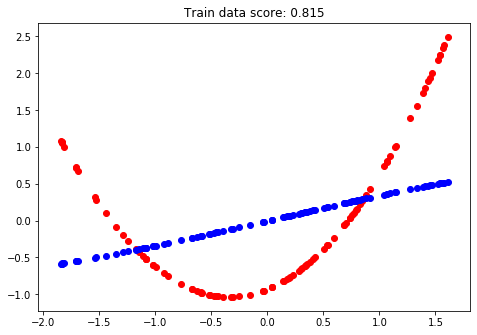

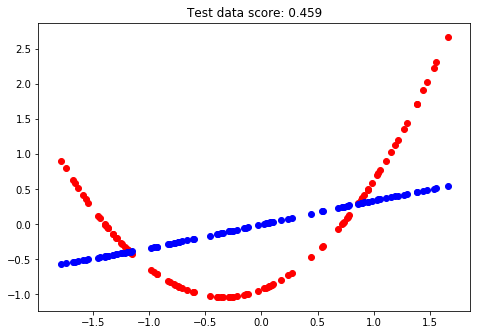

In [94]:
best=df[0:6].nsmallest(1, 'score_test').index[0]
mlp_test=networks[best]

output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")
ax.set(title='Train data score: ' +str(round(ML.MSE(train_output_layer,output_layer)/output_layer.shape[0],3)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer, test_output_layer, color='r')
ax.scatter(test_input_layer,output_layer,color="b")
ax.set(title='Test data score: ' +str(round(ML.MSE(test_input_layer,output_layer)/output_layer.shape[0],3)))

## multimodal-small

In [95]:
test = np.loadtxt("mio1/regression/multimodal-small-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))
np.random.shuffle(test)
X=test[:,0:1]
Y=test[:,1:2]
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=(Y-np.mean(Y,axis=0))/np.std(Y,axis=0)

In [96]:
test = np.loadtxt("mio1/regression/multimodal-small-test.csv", delimiter=',', skiprows=1, usecols=range(1,3))
X1=test[:,0:1]
Y1=test[:,1:2]
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=(Y1-np.mean(Y,axis=0))/np.std(Y,axis=0)

[Text(0.5, 1.0, 'Training Set')]

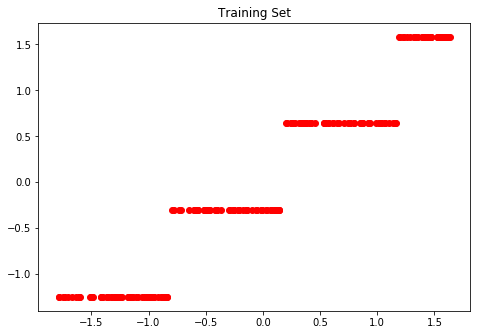

In [97]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.set(title="Training Set")

In [98]:
for L in [[5],[5,5],[10],[3,4,3],[6,6,6],[3,3,3,3]]:
    mlp_test=ML.MLP_new(1,1,L,[ML.sigmoid]*len(L)+[ML.identity],[ML.sigmoid_grad]*len(L)+[ML.identity_grad],ML.MSE,ML.MSE_grad)
        
    start_time = time.time()
    er=mlp_test.train(train_input_layer,train_output_layer,max_epoch=MAX_EPOCH,Verbose=False)
    end_time = time.time()
    t=end_time - start_time
        
    networks.append(deepcopy(mlp_test))
    networks_err.append(er.copy())
    networks_names.append("multimodal-small-"+str(L))
    
    output_layer=mlp_test.calculate(train_input_layer)
    score_train=ML.MSE(train_output_layer,output_layer)/output_layer.shape[0]
    output_layer=mlp_test.calculate(test_input_layer)
    score_test=ML.MSE(test_output_layer,output_layer)/output_layer.shape[0]
    
    L1=sum([np.sum(w**2) for w in mlp_test.weights])
    L2=sum([np.sum(np.abs(w)) for w in mlp_test.weights])
    
    rows_train=train_input_layer.shape[0]
    rows_test=test_input_layer.shape[0]
    columns_input=train_input_layer.shape[1]
    columns_output=train_output_layer.shape[1]
    connections=sum([L[i]*L[i+1] for i in range(len(L)-1)])+columns_input*L[0]+columns_output*L[-1]
    neurons=sum(L)
    L1=L1/connections
    L2=L2/connections
    model_n+=1
    df=df.append({"model_n":model_n,"problem":"regresion","dataset":"multimodal-small","columns_input":columns_input,"columns_output":columns_output,
                  "rows_train":rows_train,"rows_test":rows_test,"layers":len(L),"neurons":neurons,"connections":connections,
                  "L1":L1,"L2":L2,"regularization":"None","alpha":0,"activation_function":"sigmoid",
                         "validate":0,"score_train":score_train,"score_test":score_test,"cost_function":"MSE",
                         "epochs":len(er)-1,"time":t,"rate":0.1,"beta":0,"RMSprop":False,"batch":1},ignore_index=True)

start error 321.7976280230672
end in epoch 100 with error 44.111257757960274
start error 277.4351535695655
end in epoch 100 with error 126.42405486879483
start error 496.9766645074266
end in epoch 100 with error 16.043135295501326
start error 224.31164324151158
end in epoch 100 with error 199.65285337945443
start error 208.52250624934396
end in epoch 100 with error 189.3391159255204
start error 280.7007262426591
end in epoch 35 with error 199.90175047874686


## Best Model

[Text(0.5, 1.0, 'Test data score: 0.018')]

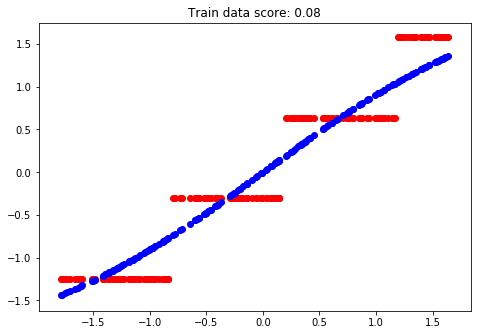

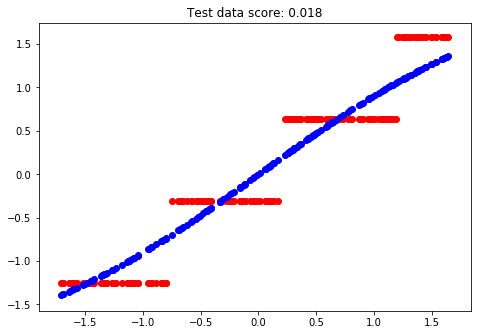

In [99]:
best=df[6:12].nsmallest(1, 'score_test').index[0]
mlp_test=networks[best]

output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer, train_output_layer, color='r')
ax.scatter(train_input_layer,output_layer,color="b")
ax.set(title='Train data score: ' +str(round(ML.MSE(train_output_layer,output_layer)/output_layer.shape[0],3)))

output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer, test_output_layer, color='r')
ax.scatter(test_input_layer,output_layer,color="b")
ax.set(title='Test data score: ' +str(round(ML.MSE(test_input_layer,output_layer)/output_layer.shape[0],3)))

## xor3

In [103]:
test = np.loadtxt("mio1/classification/xor3-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [104]:
test = np.loadtxt("mio1/classification/xor3-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X1=test[:,0:2]
Y1=test[:,2:3]
Y1=Y1==np.unique(Y1)
Y1=np.array(Y1,dtype=int)
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y1

[Text(0.5, 1.0, 'Training data')]

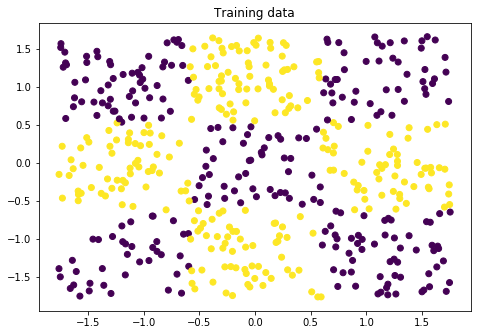

In [105]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax.set(title="Training data")

In [106]:
for L in [[5],[5,5],[10],[3,4,3],[6,6,6],[3,3,3,3]]:
    mlp_test=ML.MLP_new(2,2,L,[ML.sigmoid]*len(L)+[ML.softmax],[ML.sigmoid_grad]*len(L)+[ML.softmax_grad],ML.cross_entropy,ML.cross_entropy_grad)
        
    start_time = time.time()
    er=mlp_test.train(train_input_layer,train_output_layer,max_epoch=MAX_EPOCH,Verbose=False)
    end_time = time.time()
    t=end_time - start_time
        
    networks.append(deepcopy(mlp_test))
    networks_err.append(er.copy())
    networks_names.append("xor3-"+str(L))
    
    output_layer=mlp_test.calculate(train_input_layer)
    ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
    output_layer=mlp_test.calculate(test_input_layer)
    ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
    
    output_layer=mlp_test.calculate(train_input_layer)
    score_train=ML.cross_entropy(train_output_layer,output_layer)
    output_layer=mlp_test.calculate(test_input_layer)
    score_test=ML.cross_entropy(test_output_layer,output_layer)
    
    L1=sum([np.sum(w**2) for w in mlp_test.weights])
    L2=sum([np.sum(np.abs(w)) for w in mlp_test.weights])
    
    rows_train=train_input_layer.shape[0]
    rows_test=test_input_layer.shape[0]
    columns_input=train_input_layer.shape[1]
    columns_output=train_output_layer.shape[1]
    connections=sum([L[i]*L[i+1] for i in range(len(L)-1)])+columns_input*L[0]+columns_output*L[-1]
    neurons=sum(L)
    L1=L1/connections
    L2=L2/connections
    score_train=score_train/rows_train
    score_test=score_test/rows_test
    model_n+=1
    df=df.append({"model_n":model_n,"problem":"classification","dataset":"xor3","columns_input":columns_input,"columns_output":columns_output,
                  "rows_train":rows_train,"rows_test":rows_test,"layers":len(L),"neurons":neurons,"connections":connections,
                  "L1":L1,"L2":L2,"regularization":"None","alpha":0,"activation_function":"sigmoid",
                         "validate":0,"score_train":ac_train,"score_test":ac_test,"cost_function":"ACC",
                         "epochs":len(er)-1,"time":t,"rate":0.1,"beta":0,"RMSprop":False,"batch":1},ignore_index=True)
    
    df=df.append({"model_n":model_n,"problem":"classification","dataset":"xor3","columns_input":columns_input,"columns_output":columns_output,
                  "rows_train":rows_train,"rows_test":rows_test,"layers":len(L),"neurons":neurons,"connections":connections,
                  "L1":L1,"L2":L2,"regularization":"None","alpha":0,"activation_function":"sigmoid",
                         "validate":0,"score_train":score_train,"score_test":score_test,"cost_function":"Entropy",
                         "epochs":len(er)-1,"time":t,"rate":0.1,"beta":0,"RMSprop":False,"batch":1},ignore_index=True)

start error 359.63416360702297
end in epoch 100 with error 349.19470452924463
start error 404.57238069293646
end in epoch 47 with error 346.3468742609167
start error 362.6474939315518
end in epoch 100 with error 346.8583243898905
start error 356.0760804151636
end in epoch 44 with error 346.6092070883923
start error 408.2376689183135
end in epoch 39 with error 346.5440771953585
start error 386.4253080942235
end in epoch 60 with error 346.5877569347759


## Best Model

[Text(0.5, 1.0, 'Test data')]

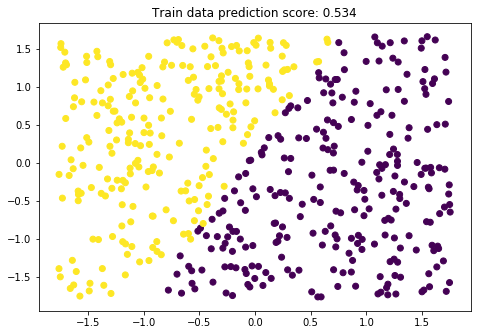

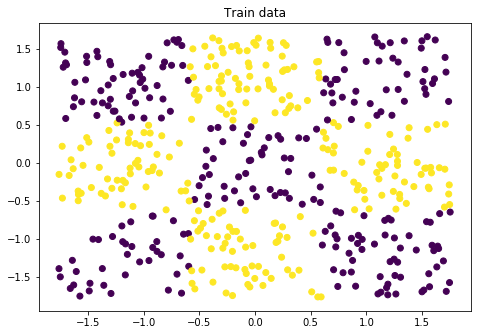

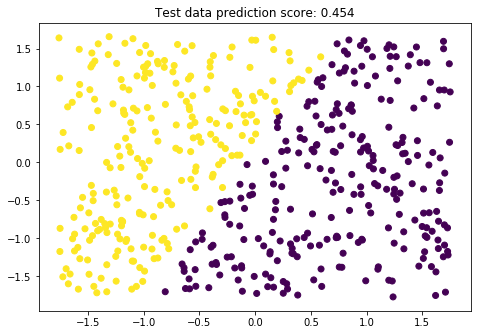

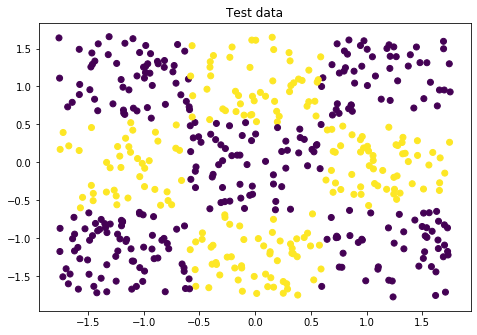

In [107]:
best=df[df["cost_function"]=="ACC"][0:6].nlargest(1, 'score_test')["model_n"].values[0]
mlp_test=networks[best]

output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Train data prediction score: '+str(round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax.set(title="Train data")


output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Test data prediction score: '+str(round(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax.set(title="Test data")

## rings5-regular

In [108]:
test = np.loadtxt("mio1/classification/rings5-regular-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [109]:
test = np.loadtxt("mio1/classification/rings5-regular-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X1=test[:,0:2]
Y1=test[:,2:3]
Y1=Y1==np.unique(Y1)
Y1=np.array(Y1,dtype=int)
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y1

[Text(0.5, 1.0, 'Training data')]

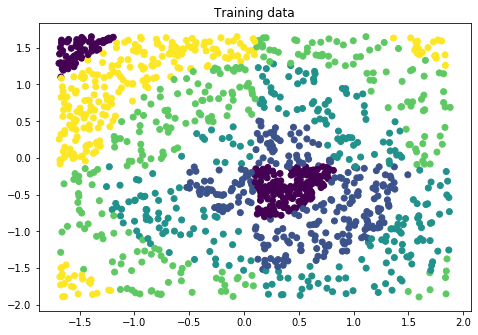

In [110]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax.set(title="Training data")

In [111]:
for L in [[5],[5,5],[10],[3,4,3],[6,6,6],[3,3,3,3]]:
    mlp_test=ML.MLP_new(2,5,L,[ML.sigmoid]*len(L)+[ML.softmax],[ML.sigmoid_grad]*len(L)+[ML.softmax_grad],ML.cross_entropy,ML.cross_entropy_grad)
        
    start_time = time.time()
    er=mlp_test.train(train_input_layer,train_output_layer,max_epoch=MAX_EPOCH,Verbose=False)
    end_time = time.time()
    t=end_time - start_time
        
    networks.append(deepcopy(mlp_test))
    networks_err.append(er.copy())
    networks_names.append("rings5-regular-"+str(L))
    
    output_layer=mlp_test.calculate(train_input_layer)
    ac_train=np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1))
    output_layer=mlp_test.calculate(test_input_layer)
    ac_test=np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1))
    
    output_layer=mlp_test.calculate(train_input_layer)
    score_train=ML.cross_entropy(train_output_layer,output_layer)
    output_layer=mlp_test.calculate(test_input_layer)
    score_test=ML.cross_entropy(test_output_layer,output_layer)
    
    L1=sum([np.sum(w**2) for w in mlp_test.weights])
    L2=sum([np.sum(np.abs(w)) for w in mlp_test.weights])
    
    rows_train=train_input_layer.shape[0]
    rows_test=test_input_layer.shape[0]
    columns_input=train_input_layer.shape[1]
    columns_output=train_output_layer.shape[1]
    connections=sum([L[i]*L[i+1] for i in range(len(L)-1)])+columns_input*L[0]+columns_output*L[-1]
    neurons=sum(L)
    L1=L1/connections
    L2=L2/connections
    score_train=score_train/rows_train
    score_test=score_test/rows_test
    
    model_n+=1
    df=df.append({"model_n":model_n,"problem":"classification","dataset":"rings5-regular","columns_input":columns_input,"columns_output":columns_output,
                  "rows_train":rows_train,"rows_test":rows_test,"layers":len(L),"neurons":neurons,"connections":connections,
                  "L1":L1,"L2":L2,"regularization":"None","alpha":0,"activation_function":"sigmoid",
                         "validate":0,"score_train":ac_train,"score_test":ac_test,"cost_function":"ACC",
                         "epochs":len(er)-1,"time":t,"rate":0.1,"beta":0,"RMSprop":False,"batch":1},ignore_index=True)
    
    df=df.append({"model_n":model_n,"problem":"classification","dataset":"rings5-regular","columns_input":columns_input,"columns_output":columns_output,
                  "rows_train":rows_train,"rows_test":rows_test,"layers":len(L),"neurons":neurons,"connections":connections,
                  "L1":L1,"L2":L2,"regularization":"None","alpha":0,"activation_function":"sigmoid",
                         "validate":0,"score_train":score_train,"score_test":score_test,"cost_function":"Entropy",
                         "epochs":len(er)-1,"time":t,"rate":0.1,"beta":0,"RMSprop":False,"batch":1},ignore_index=True)

start error 2281.41630371979
end in epoch 100 with error 1895.5876411084
start error 2095.7327004394756
end in epoch 100 with error 2010.0154803334813
start error 2178.316031195174
end in epoch 100 with error 1890.6534052595778
start error 2143.7797095803935
end in epoch 100 with error 2010.691840226461
start error 2291.101889313364
end in epoch 100 with error 2010.3389953841436
start error 2069.004299068987
end in epoch 100 with error 2011.8673812292611


## Best Model

[Text(0.5, 1.0, 'Test data')]

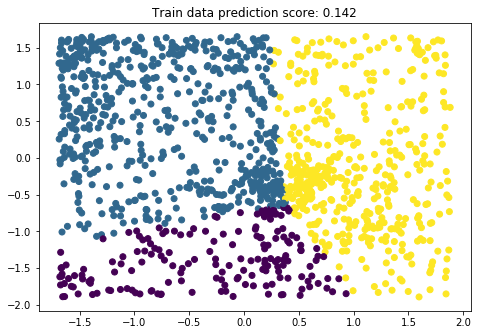

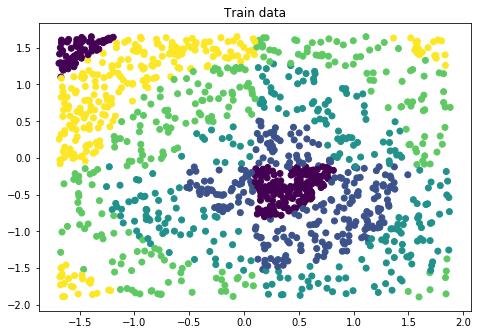

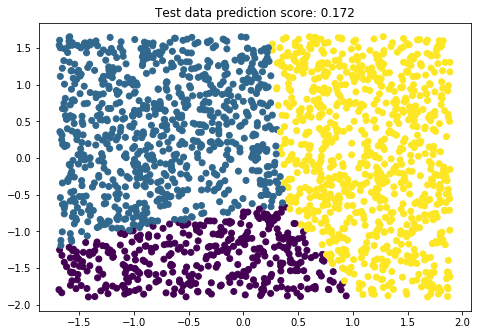

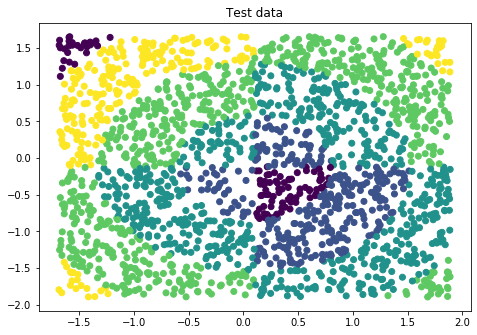

In [112]:
best=df[df["cost_function"]=="ACC"][6:12].nlargest(1, 'score_test')["model_n"].values[0]
mlp_test=networks[best]

output_layer=mlp_test.calculate(train_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Train data prediction score: '+str(round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax.set(title="Train data")


output_layer=mlp_test.calculate(test_input_layer)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Test data prediction score: '+str(round(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax.set(title="Test data")

In [113]:
df

,model_n,problem,dataset,columns_input,columns_output,rows_train,rows_test,layers,neurons,connections,...,validate,score_train,score_test,cost_function,epochs,time,rate,beta,RMSprop,batch
0,1,regresion,square-simple,1,1,100,100,1,5,10,...,0,0.901604,0.696723,MSE,100,0.476619,0.1,0,False,1
1,2,regresion,square-simple,1,1,100,100,2,10,35,...,0,0.938533,0.733579,MSE,100,0.825806,0.1,0,False,1
2,3,regresion,square-simple,1,1,100,100,1,10,20,...,0,0.814624,0.607790,MSE,100,0.422674,0.1,0,False,1
3,4,regresion,square-simple,1,1,100,100,3,10,30,...,0,0.999711,0.796522,MSE,100,1.152278,0.1,0,False,1
4,5,regresion,square-simple,1,1,100,100,3,18,84,...,0,0.986581,0.783016,MSE,100,1.131880,0.1,0,False,1
5,6,regresion,square-simple,1,1,100,100,4,12,33,...,0,0.999792,0.796379,MSE,31,0.466410,0.1,0,False,1
6,7,regresion,multimodal-small,1,1,200,200,1,5,10,...,0,0.220556,0.213848,MSE,100,0.883628,0.1,0,False,1
7,8,regresion,multimodal-small,1,1,200,200,2,10,35,...,0,0.632120,0.615168,MSE,100,1.446992,0.1,0,False,1
8,9,regresion,multimodal-small,1,1,200,200,1,10,20,...,0,0.080216,0.078697,MSE,100,0.954600,0.1,0,False,1
9,10,regresion,multimodal-small,1,1,200,200,3,10,30,...,0,0.998264,0.969218,MSE,100,2.260267,0.1,0,False,1


In [115]:
df_c=df[df["problem"]=="classification"]

In [116]:
df_r=df[df["problem"]!="classification"]

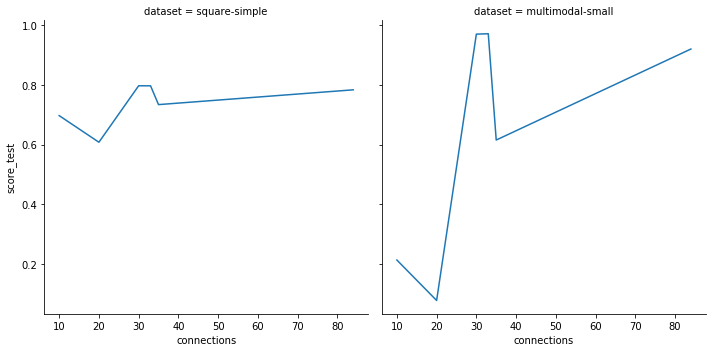

In [154]:
sns.relplot(x="connections",y="score_test",col="dataset",kind="line",data=df_r)

In [ ]:
#jak widzimy regularyzacja nie wpływa korzystnie na wyniki zaś w przypadku walidacji brak to czasami pomaga, a czasami przeszkadza lub bez wpływu

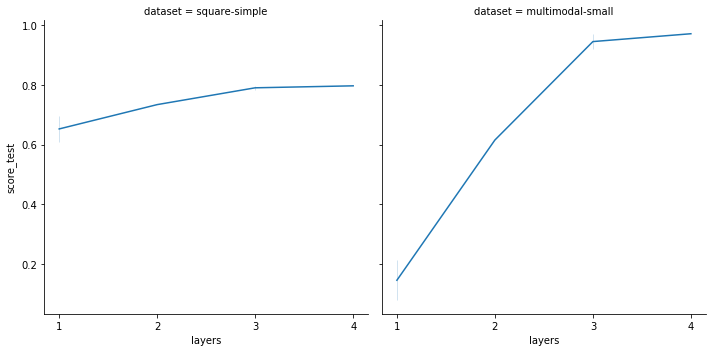

In [149]:
sns.relplot(x="layers",y="score_test",col="dataset",kind="line",data=df_r)

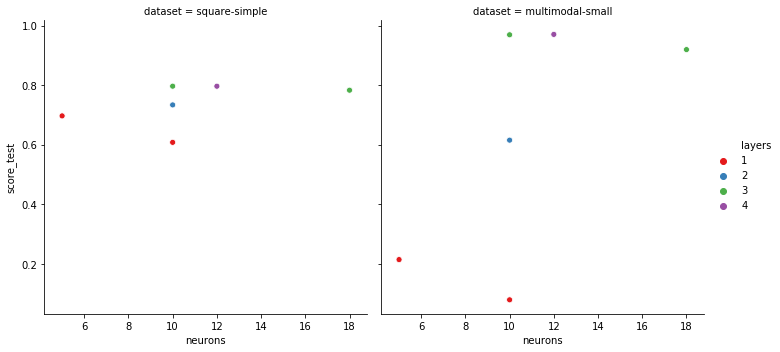

In [146]:
sns.relplot(x="neurons",y="score_test",col="dataset",hue="layers",kind="scatter",data=df_r,palette=sns.color_palette("Set1", df_r.layers.nunique()))

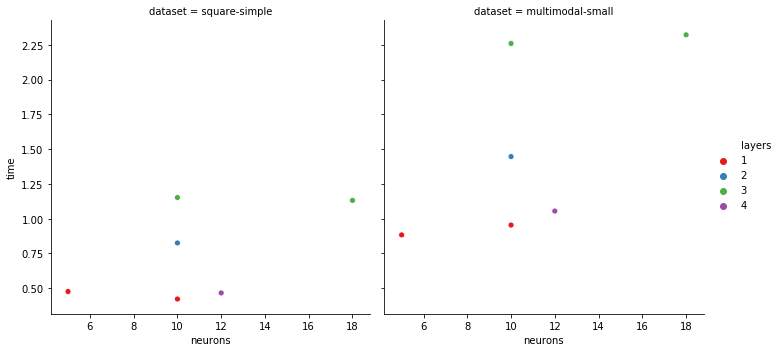

In [155]:
sns.relplot(x="neurons",y="time",col="dataset",hue="layers",kind="scatter",data=df_r,palette=sns.color_palette("Set1", df_r.layers.nunique()))

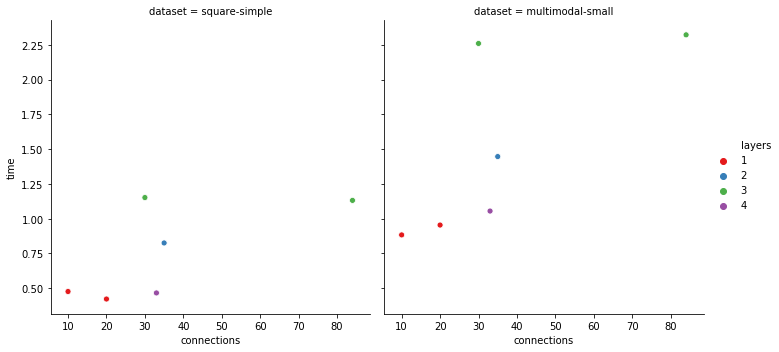

In [156]:
sns.relplot(x="connections",y="time",col="dataset",hue="layers",kind="scatter",data=df_r,palette=sns.color_palette("Set1", df_r.layers.nunique()))

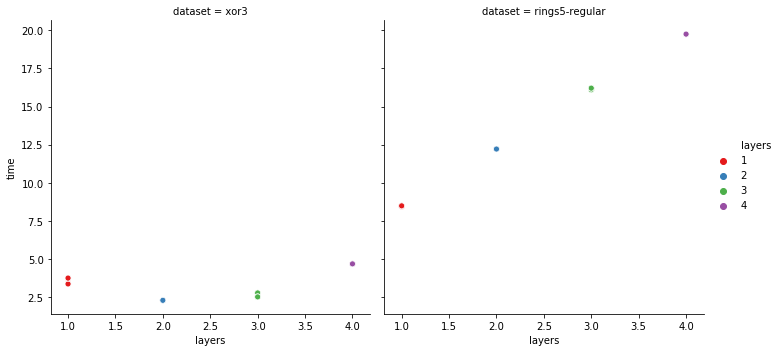

In [160]:
sns.relplot(x="layers",y="time",col="dataset",hue="layers",kind="scatter",data=df_c,palette=sns.color_palette("Set1", df_r.layers.nunique()))

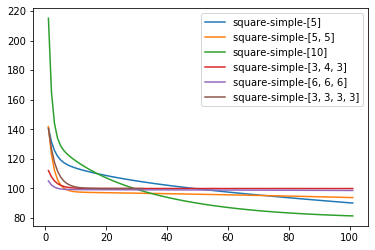

In [125]:
for x in range(0,6):
    t=np.arange(1,len(networks_err[x])+1,1)
    if networks_err[x][-1]<10**10:
        plt.plot(t,networks_err[x],label=networks_names[x])
    
plt.legend(loc="upper right")  